<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/google_colab_examples/dssat_spatial_crop_simulation_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

import os
os.chdir('/content/WeatherSoilDataProcessor')

!git clone https://github.com/daquinterop/Py_DSSATTools.git

!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

In [ ]:
!pip install hvplot panel param geoviews bokeh jupyter_bokeh -U
from google.colab import output
output.enable_custom_widget_manager()

# Run spatial Crop Simulation using at pixel-scale resolution

In this example, we show how to simulate the potential yield of a specific crop at a fine spatial resolution (250m), aligned with the SoilGrids project resolution. The simulation requires detailed information on soil and weather conditions, as well as specified management practices.

## Repository Structure
The repository consists of three main components:

1. [**Download Spatial Data:**](#downloaddata)  
  - Weather Data
  - Soil Data

2. [**Data Cube Creation:**](#datacube)
  - Set configuration parameters
  - Spatial visualization
  - Export data as NetCDF files

3. [**Crop Modeling Using the DSSAT Model:**](#cropmodel)
  - Configuration file setup
  - Running DSSAT
  - Plotting the results

## 1. Download Spatial Data<a id="downloaddata"></a>



### Weather Data

In this section, we will download historical weather data . The information will be downloaded mainly from two sources [CHIRPS](https://www.chc.ucsb.edu/data/chirps) and [AgERA5](https://cds.climate.copernicus.eu/datasets/sis-agrometeorological-indicators?tab=overview).

To access AgERA5 data, users must provide account credentials. This requires two key pieces of information:

- Email – The email address used to register the AgERA5 account.
- API Code – A unique code available in the profile settings after account creation.

The following command is used to authenticate and access AgERA5 data:

In [19]:
YOURUSERAPICODE = 'your_api_code'#
YOUREMAIL = 'your_email@example.com'

with open("/root/.cdsapirc", "w") as f:
  f.write("url: https://cds.climate.copernicus.eu/api\nkey: {}\nemail: ".format(YOURUSERAPICODE, YOUREMAIL))

After, we set the configuration dictionary that defines the parameters for the weather data download, such as the time period, geographical extent, and the output folder path.

In [29]:
import os
os.chdir('/content/WeatherSoilDataProcessor')

import geopandas as gpd
from omegaconf import OmegaConf

from spatialdata.climate_data import MLTWeatherDataCube, ClimateDataDownload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {
    'DATES': {
        'starting_date':'2001-01-01',
        'ending_date': '2001-12-31'},
    'SPATIAL_INFO': {
          'spatial_file': 'data/country.shp',
          'extent': None #[-90, 12, -83, 17]
    },
    'WEATHER': { ## weather information
        'variables': { # variables to download
              'precipitation': {'mission': 'chirps', 'source': 'chips'},
              'solar_radiation': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmax': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmin': {'mission': 'agera5', 'source': 'agera5'}
        },
    },
    'GENERAL': {
        'suffix': 'hnd',
        'ncores': 10,
    },
    'PATHS':{
        'output_path': 'weather/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

In [46]:
if config.SPATIAL_INFO.get('spatial_file',None):
    extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), round_numbers = True)
else:
    extent = config.SPATIAL_INFO.extent

print(f"from {config.DATES.starting_date} to {config.DATES.ending_date}" )
climatedata = ClimateDataDownload(starting_date= config.DATES.starting_date,
                                    ending_date= config.DATES.ending_date,
                                    xyxy= extent,
                                    output_folder= config.PATHS.output_path)

climatedata.download_weather_information(config.WEATHER.variables, suffix_output_folder=config.GENERAL.suffix, ncores = config.GENERAL.ncores)

### Soil Data

In this section, we will download soil data information for different depths. Currently the information is downloaded from [SoilGrids](https://soilgrids.org/) project.


In [39]:
from spatialdata.soil_data import SoilGridDataDonwload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {

    'SPATIAL_INFO': {
          'spatial_file': 'data/country.shp',
          'extent': None, #[-90, 12, -83, 17],
          'crs': 'ESRI:54052' ## soilgrids proejection system
    },
    'SOIL': { ## weather information
          'variables': ["clay",  "sand", "silt", "wv0010","cec", "wv0033", "wv1500"],
          'depths': ["0-5","5-15","15-30","30-60"]
    },
    'GENERAL': {
        'suffix': 'hnd'
    },
    'PATHS':{
        'output_path': 'soil/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': 'data/country.shp', 'extent': None, 'crs': 'ESRI:54052'}

In [41]:
if config.SPATIAL_INFO.get('spatial_file',None):
    extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), crs = config.SPATIAL_INFO.crs, round_numbers = True)
else:
    extent = config.SPATIAL_INFO.extent

outputpath = os.path.join(config.PATHS.output_path, config.GENERAL.suffix)

soildata = SoilGridDataDonwload(soil_layers= config.SOIL.variables,
                            depths= config.SOIL.depths,
                            output_folder= outputpath)

soildata.download_soilgrid(boundaries= extent)

File created: clay_0-5cm_mean.tif 
File created: clay_5-15cm_mean.tif 
File created: clay_15-30cm_mean.tif 
File created: clay_30-60cm_mean.tif 
File created: sand_0-5cm_mean.tif 
File created: sand_5-15cm_mean.tif 
File created: sand_15-30cm_mean.tif 
File created: sand_30-60cm_mean.tif 
File created: silt_0-5cm_mean.tif 
File created: silt_5-15cm_mean.tif 
File created: silt_15-30cm_mean.tif 
File created: silt_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_0-5cm_mean.tif


File created: wv0010_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_5-15cm_mean.tif


File created: wv0010_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_15-30cm_mean.tif


File created: wv0010_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_30-60cm_mean.tif


File created: wv0010_30-60cm_mean.tif 
File created: cec_0-5cm_mean.tif 
File created: cec_5-15cm_mean.tif 
File created: cec_15-30cm_mean.tif 
File created: cec_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_0-5cm_mean.tif


File created: wv0033_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_5-15cm_mean.tif


File created: wv0033_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_15-30cm_mean.tif


File created: wv0033_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_30-60cm_mean.tif


File created: wv0033_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_0-5cm_mean.tif


File created: wv1500_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_5-15cm_mean.tif


File created: wv1500_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_15-30cm_mean.tif


File created: wv1500_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_30-60cm_mean.tif


File created: wv1500_30-60cm_mean.tif 


## 2. Data Cube Creation<a id="datacube"></a>

### Set configuration parameters
To implement this, it is necessary to have spatial information for soil and climate. We can create a datacube with dimensions height, width, channel, and date for weather, and height, width, channel, and depth for soil.

An example of the spatial configuration is available in the options folder. Here, we will define it as a dictionary variable.

In [42]:
## creating
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialData

configuration_info = {
    'GENERAL_INFO': {'projected_crs':'ESRI:54052'},
    'SPATIAL_VECTOR': {
        'boundaries': "data/country.shp" # geo spatial file that will define the spatial boundaries
    },
    'WEATHER': { ## weather information
        'setup_parameters': { # parameters to create the datacube
            'paths':{ # path that allows each one of the meteorological variables information
                'precipitation': "weather/precipitation_hnd_raw",
                'srad': "weather/solar_radiation_hnd_raw",
                'tmax': "weather/temperature_tmax_hnd_raw",
                'tmin': "weather/temperature_tmin_hnd_raw"
            },
            'crs': 'EPSG:4326', ## spatial coordinates system
            'period': ['2001-01-01', '2001-12-31'] ,
            'reference_variable': 'precipitation' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    },
    'SOIL': {
        'setup_parameters': { # parameters to create the datacube
            'path': "soil/hnd/",
            'variables': ["bdod","clay","sand", "silt"],
            'depths': ["0-5","5-15","15-30","30-60"],
            'crs': 'ESRI:54052', ## SOILGRIDS spatial coordinates system
            'reference_variable': 'sand' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    }
}

In [43]:

# Initialize SpatialData with the configuration dictionary
spdata = SpatialData(configuration_dict=configuration_info)

# Retrieve climate data
spdata.get_climate_data()

# Retrieve soil data
spdata.get_soil_data()

weather/precipitation_hnd_raw/2001
weather/solar_radiation_hnd_raw/2001
weather/temperature_tmax_hnd_raw/2001
weather/temperature_tmin_hnd_raw/2001


100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]

100%|██████████| 4/4 [00:00<00:00, 608.07it/s]


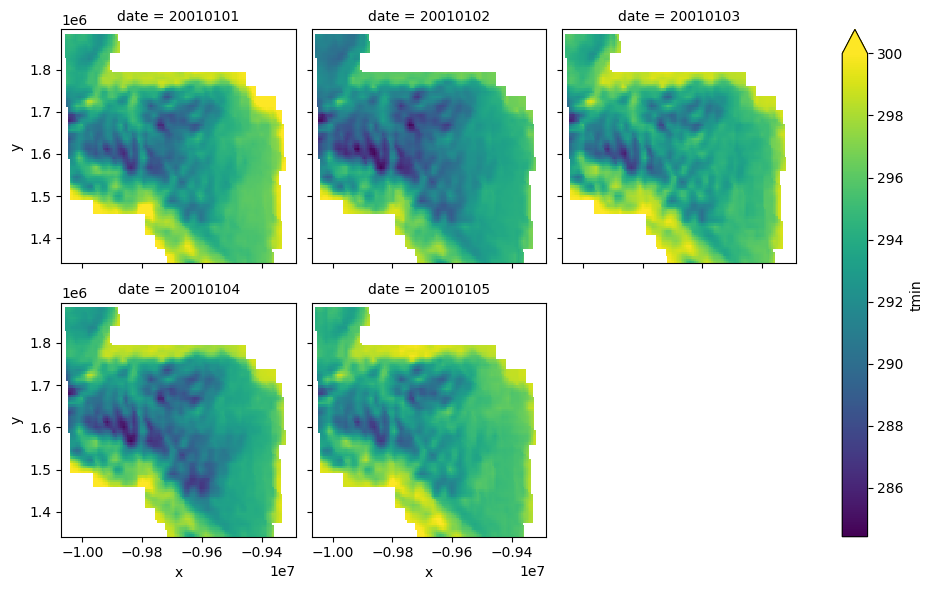

In [36]:
## plots

g_simple = spdata.climate.tmin.isel(date = list(range(5))).plot(x="x", y="y", col="date", col_wrap=3, vmax = 300)

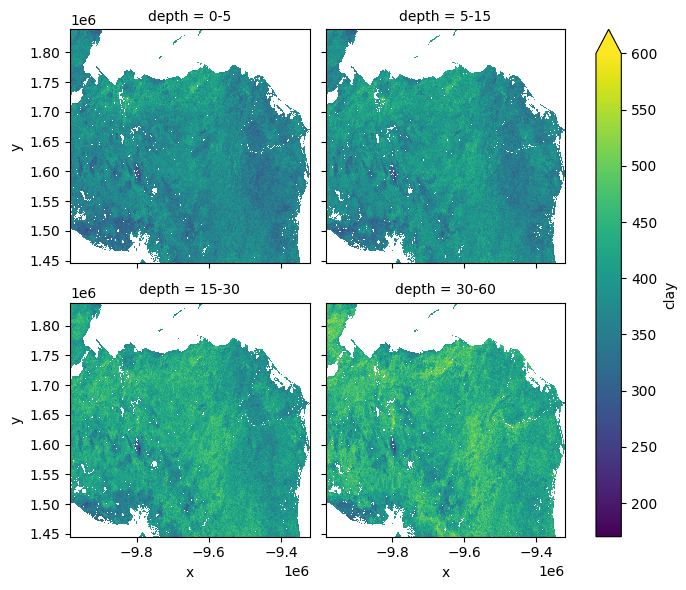

In [ ]:
# texture values in soil grids data is multiply by 10
g_simple = spdata.soil.clay.plot(x="x", y="y", col="depth", col_wrap=2, vmax = 600)

In [37]:
# save data as datacubes
spdata._save_asnc(spdata.soil, fn = 'soil/soil_hnd.nc')
spdata._save_asnc(spdata.climate, fn = 'weather/weather_hnd.nc')

## 3. Crop Modeling Using the DSSAT Model<a id="cropmodel"></a>




### Configuration file setup

Once the spatial data has been configured.

To specify that the analysis will be done at pixel-scale, we set 'pixel' in the configuration dictionary.

Other parameters to configure include crop parameters and management practices. Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.

In [45]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
import sys
sys.path.append("/content/WeatherSoilDataProcessor/Py_DSSATTools/")
from crop_modeling.spatial_process import SpatialCM
import numpy as np
import pandas as pd

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 10,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': 'data/tb_limitealdeas.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'pixel',
        'soil_path' : 'soil/soil_hnd.nc',
        'weather_path': 'weather/weather_hnd.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': '990002', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '2001-04-01',
        'harvesting_date': '2001-08-30',
        'plantingWindow': 15, # planting window in weeks
        'fertilizer': False, # It is not implemented yet
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}



### Running DSSAT

In [48]:
# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)

# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features['GEOCODIGO']==str('180617')]
roi

loaded from soil/soil_hnd.nc
loaded from weather/weather_hnd.nc


,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
1013,180617,Nueva Esperanza,180617,1806,18,31.1869,64.2257,Morazan,Yoro,3118.687068,"POLYGON ((-87.59532 15.29991, -87.59527 15.299..."


In [49]:

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    roi= roi,
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')

100%|██████████| 133/133 [02:13<00:00,  1.00s/it]


Configuration file written: runs/180617/274/experimental_file_config.yaml
experimental file created: ['runs/180617/274/EXPS0001.MZX']
Configuration file written: runs/180617/100/experimental_file_config.yaml
experimental file created: ['runs/180617/100/EXPS0001.MZX']
Configuration file written: runs/180617/103/experimental_file_config.yaml
experimental file created: ['runs/180617/103/EXPS0001.MZX']
Configuration file written: runs/180617/198/experimental_file_config.yaml
experimental file created: ['runs/180617/198/EXPS0001.MZX']
Configuration file written: runs/180617/142/experimental_file_config.yaml
experimental file created: ['runs/180617/142/EXPS0001.MZX']
Configuration file written: runs/180617/392/experimental_file_config.yaml
experimental file created: ['runs/180617/392/EXPS0001.MZX']
Configuration file written: runs/180617/295/experimental_file_config.yaml
experimental file created: ['runs/180617/295/EXPS0001.MZX']
Configuration file written: runs/180617/78/experimental_file_c

100%|██████████| 133/133 [02:18<00:00,  1.04s/it]

{'274': True, '100': True, '103': True, '198': True, '142': True, '392': True, '295': True, '78': True, '122': True, '315': True, '413': True, '414': True, '143': True, '316': True, '196': True, '118': True, '252': True, '372': True, '258': True, '332': True, '393': True, '219': True, '97': True, '138': True, '137': True, '375': True, '80': True, '257': True, '136': True, '123': True, '81': True, '235': True, '312': True, '334': True, '273': True, '432': True, '200': True, '410': True, '83': True, '176': True, '177': True, '313': True, '277': True, '394': True, '62': True, '64': True, '415': True, '232': True, '181': True, '292': True, '175': True, '314': True, '99': True, '352': True, '215': True, '61': True, '216': True, '234': True, '253': True, '77': True, '157': True, '158': True, '120': True, '144': True, '272': True, '214': True, '155': True, '195': True, '373': True, '275': True, '354': True, '141': True, '124': True, '197': True, '63': True, '391': True, '434': True, '412': Tr

### Crop simulation outputs

After completing the simulation, the next step is to generate the output maps.


In [50]:
from crop_modeling.dssat.output import update_dssat_data_using_path
from crop_modeling.spatial_process import create_mlt_yield_raster
import rioxarray as rio
import matplotlib.pyplot as plt


refraster = rio.open_rasterio(os.path.join(cm_sp._tmp_path,'ref_raster.tif'))
model_data = update_dssat_data_using_path(cm_sp._tmp_path)

mlt_pot_yield = create_mlt_yield_raster(refraster, model_data, ycol_name='HWAH')


100%|██████████| 15/15 [00:00<00:00, 237.00it/s]


### Plotting the results

In [51]:
import hvplot.xarray
import holoviews as hv
import panel as pn

hv.extension("bokeh")
minlim = mlt_pot_yield.HWAH.min().values
maxlim = mlt_pot_yield.HWAH.max().values

mltmap = mlt_pot_yield.HWAH.hvplot.image(x='x', y='y', groupby = 'date',frame_height = 600, frame_width= 400, cmap='YlGnBu', fontscale=1.6, crs='EPSG:4326', tiles = 'EsriImagery', clim=(minlim,maxlim))

dmap_panel = pn.panel(mltmap)
dmap_panel


Row
    [0] HoloViews(DynamicMap, sizing_mode='fixed')
    [1] WidgetBox(align=('end', 'start'))
        [0] DiscreteSlider(name='date', options={'2001-04-01 00:00:00': np...}, value=np.datetime64('2001-04-01T...)

In [52]:
spdata._save_asnc(mlt_pot_yield, fn = os.path.join(cm_sp._tmp_path,'potential_yield.nc'))

In [53]:
import hvplot.pandas
boxplot = mlt_pot_yield.HWAH.hvplot.box('HWAH', by=['date'], rot=90, box_fill_color='lightblue', width=1600, height=450).opts(ylim=(1285,9969))
dmap_panel = pn.panel(boxplot)
dmap_panel

HoloViews(BoxWhisker, height=450, sizing_mode='fixed', width=1600)